In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_rows', 100)

from scipy.stats import rankdata

import seaborn as sns
import matplotlib.pyplot as plt

import pickle

In [3]:
def create_validation_features ():
    df_valid_pair = pd.read_csv("../processed/validation.csv")
    df_valid_fe = pd.read_csv("../processed/valid_text_detoxify_fe.csv")

    df_valid_fe_2 = pd.read_csv("../processed/valid_text_jc_tfidf_fe.csv")
    df_valid_fe_2 = df_valid_fe_2[["jc_tfidf_toxic","jc_tfidf_severe_toxic","jc_tfidf_obscene","jc_tfidf_threat","jc_tfidf_insult","jc_tfidf_identity_hate"]]
    
    df_valid_fe_3 = pd.read_csv("../processed/valid_text_juc_tfidf_fe.csv")
    df_valid_fe_3 = df_valid_fe_3[['juc_tfidf_toxicity', 'juc_tfidf_severe_toxicity','juc_tfidf_obscene', 'juc_tfidf_sexual_explicit','juc_tfidf_identity_attack', 'juc_tfidf_insult', 'juc_tfidf_threat']]
    
    df_valid_fe = pd.concat ( [df_valid_fe,df_valid_fe_2, df_valid_fe_3], axis=1)    
    
    return df_valid_pair, df_valid_fe

    
def create_rud_features ():
    df_valid_pair = pd.read_csv("../processed/rud_pair.csv")
    df_valid_fe = pd.read_csv("../processed/rud_text_detoxify_fe.csv")

    df_valid_fe_2 = pd.read_csv("../processed/rud_text_jc_tfidf_fe.csv")
    df_valid_fe_2 = df_valid_fe_2[["jc_tfidf_toxic","jc_tfidf_severe_toxic","jc_tfidf_obscene","jc_tfidf_threat","jc_tfidf_insult","jc_tfidf_identity_hate"]]

    df_valid_fe_3 = pd.read_csv("../processed/rud_text_juc_tfidf_fe.csv")
    df_valid_fe_3 = df_valid_fe_3[['juc_tfidf_toxicity', 'juc_tfidf_severe_toxicity','juc_tfidf_obscene', 'juc_tfidf_sexual_explicit','juc_tfidf_identity_attack', 'juc_tfidf_insult', 'juc_tfidf_threat']]
    
    df_valid_fe = pd.concat ( [df_valid_fe,df_valid_fe_2, df_valid_fe_3], axis=1)    
    
    return df_valid_pair, df_valid_fe


def validate(df_valid_pair,df_valid_text, pred):
    

    ### rud
    if "comment_id" in df_valid_text.columns:
        m = { a:b for a, b in zip(df_valid_text["comment_id"].values, pred)  }
        p_less = df_valid_pair["less_toxic_id"].map(lambda x: m[x] )
        p_more = df_valid_pair["more_toxic_id"].map(lambda x: m[x] )
        return (p_less < p_more).mean()
    
    else:
        m = { a:b for a, b in zip(df_valid_text["text"].values, pred)  }
        
        df_valid_pair = df_valid_pair.copy()
        #df_valid_pair = df_valid_pair.query("count == 3").copy()
        
        df_valid_pair["less_toxic_score"] = df_valid_pair["less_toxic"].map(lambda x: m[x] )
        df_valid_pair["more_toxic_score"] = df_valid_pair["more_toxic"].map(lambda x: m[x] )
        
        d_a = df_valid_pair.query("less_toxic_score < more_toxic_score and avg_agreement == 1.0") 
        d_b = df_valid_pair.query("less_toxic_score < more_toxic_score and avg_agreement < 1.0") 
        d_c = df_valid_pair.query("less_toxic_score > more_toxic_score and avg_agreement < 1.0") 

        return (d_a["count"].sum() + d_b.shape[0]*2 + d_c.shape[0])/df_valid_pair["count"].sum()
    

def avg_predict (df_valid_text, cols):
    for k, col in enumerate(cols):
        p = rankdata(df_valid_text[col].values, method='ordinal')

        if k == 0:
            y = p
        else:    
            y = y + p  
    return y

def sklearn_predict (df_valid_text, model_path, model_name, cols, folds = 5):
    pred = np.zeros ((df_valid_text.shape[0]))
    X = df_valid_text [cols].values


    for fold in range(5):
        model = pickle.load(open(f"{model_path}/{model_name}_{fold}.pkl", 'rb'))

        pred += model.predict ( X )
        
    return pred

In [4]:
val_pair, val_text = create_validation_features ()
rud_pair, rud_text = create_rud_features ()

### Single Features

In [5]:
cols = ['original_toxicity', 'original_severe_toxicity', 'original_obscene',
       'original_threat', 'original_insult', 'original_identity_attack',
       'unbiased_toxicity', 'unbiased_severe_toxicity', 'unbiased_obscene',
       'unbiased_identity_attack', 'unbiased_insult', 'unbiased_threat',
       'unbiased_sexual_explicit', 'multilingual_toxicity',
       'multilingual_severe_toxicity', 'multilingual_obscene',
       'multilingual_identity_attack', 'multilingual_insult',
       'multilingual_threat', 'multilingual_sexual_explicit',
       'original-small_toxicity', 'original-small_severe_toxicity',
       'original-small_obscene', 'original-small_threat',
       'original-small_insult', 'original-small_identity_attack',
       'unbiased-small_toxicity', 'unbiased-small_severe_toxicity',
       'unbiased-small_obscene', 'unbiased-small_identity_attack',
       'unbiased-small_insult', 'unbiased-small_threat',
       'unbiased-small_sexual_explicit', 
       "jc_tfidf_toxic","jc_tfidf_severe_toxic","jc_tfidf_obscene","jc_tfidf_threat","jc_tfidf_insult","jc_tfidf_identity_hate",
       'juc_tfidf_toxicity', 'juc_tfidf_severe_toxicity','juc_tfidf_obscene', 'juc_tfidf_sexual_explicit','juc_tfidf_identity_attack', 'juc_tfidf_insult', 'juc_tfidf_threat'
       ]

names = []
ruds = []
vals = []
for col in cols:
    y = avg_predict (rud_text, [col])
    rud_score = validate (rud_pair,rud_text, y)

    y = avg_predict (val_text, [col])
    val_score = validate (val_pair,val_text, y)
    
    names.append (col)
    ruds.append (rud_score)
    vals.append (val_score)
    

df = pd.DataFrame ({
    "feature":names,
    "val_score":vals,
    "rud_score":ruds,
}
)

df = df.sort_values(by="val_score", ascending=False).reset_index(drop=True)
df.to_csv("../processed/single_feature_validation.csv", index=False)
df

,feature,val_score,rud_score
0,multilingual_toxicity,0.698718,0.804920
1,original_severe_toxicity,0.696028,0.738255
2,original_toxicity,0.695596,0.792260
3,unbiased_severe_toxicity,0.695430,0.787636
4,original-small_severe_toxicity,0.695197,0.745885
5,unbiased_toxicity,0.693570,0.814118
6,original-small_toxicity,0.693271,0.754579
7,original_obscene,0.690846,0.764314
8,original_insult,0.689783,0.784862
9,original-small_insult,0.689617,0.752488


### Ridge, RF, LGB, XGB Models

In [6]:
cols = ['original_toxicity', 'original_severe_toxicity', 'original_obscene',
       'original_threat', 'original_insult', 'original_identity_attack',
       'unbiased_toxicity', 'unbiased_severe_toxicity', 'unbiased_obscene',
       'unbiased_identity_attack', 'unbiased_insult', 'unbiased_threat',
       'unbiased_sexual_explicit', 'multilingual_toxicity',
       'multilingual_severe_toxicity', 'multilingual_obscene',
       'multilingual_identity_attack', 'multilingual_insult',
       'multilingual_threat', 'multilingual_sexual_explicit',
       'original-small_toxicity', 'original-small_severe_toxicity',
       'original-small_obscene', 'original-small_threat',
       'original-small_insult', 'original-small_identity_attack',
       'unbiased-small_toxicity', 'unbiased-small_severe_toxicity',
       'unbiased-small_obscene', 'unbiased-small_identity_attack',
       'unbiased-small_insult', 'unbiased-small_threat',
       'unbiased-small_sexual_explicit', 
        "jc_tfidf_toxic","jc_tfidf_severe_toxic","jc_tfidf_obscene","jc_tfidf_threat","jc_tfidf_insult","jc_tfidf_identity_hate"]


for model_name in ["ridge_rud", "rf_rud", "lgb_rud", "xgb_rud"]:
    y = sklearn_predict (val_text, model_path = "../models/", model_name =model_name, cols=cols)
    val_score = validate (val_pair,val_text, y)
    print(f"{model_name}: {val_score:.5f}")    



ridge_rud: 0.70051
rf_rud: 0.70742


lgb_rud: 0.70636
xgb_rud: 0.70231


###  Mean Models

In [7]:
cols = ['original_toxicity', 'original_severe_toxicity', 
        'unbiased_toxicity', 'unbiased_severe_toxicity', 'unbiased_identity_attack', 'unbiased_insult', 
        'multilingual_toxicity', 'multilingual_sexual_explicit', 
        'original-small_toxicity', 
        'unbiased-small_severe_toxicity', 'unbiased-small_obscene', 
        'jc_tfidf_toxic']


y = avg_predict (rud_text, cols)
rud_score = validate (rud_pair,rud_text, y)

y = avg_predict (val_text, cols)
val_score = validate (val_pair,val_text, y)
print(f"Mean of {cols}\nVAL: {val_score:.5f}, RUD: {rud_score:.5f}")    

Mean of ['original_toxicity', 'original_severe_toxicity', 'unbiased_toxicity', 'unbiased_severe_toxicity', 'unbiased_identity_attack', 'unbiased_insult', 'multilingual_toxicity', 'multilingual_sexual_explicit', 'original-small_toxicity', 'unbiased-small_severe_toxicity', 'unbiased-small_obscene', 'jc_tfidf_toxic']
VAL: 0.70858, RUD: 0.80888


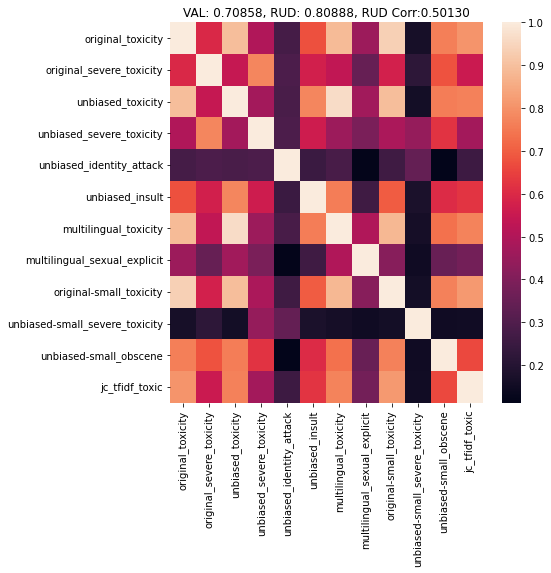

In [8]:
df_corr = rud_text[cols].copy()
for col in cols:
    rud_text[col] = rankdata ( rud_text[col].values )
corr = df_corr.corr()    

A = corr.values
m = A.shape[0]
r,c = np.triu_indices(m,1)
corr_mean = A[r,c].mean()

plt.figure (figsize=(7,7))
sns.heatmap (corr)
plt.title(f"VAL: {val_score:.5f}, RUD: {rud_score:.5f}, RUD Corr:{corr_mean:.5f}")
plt.show()

In [9]:
cols = ['original_toxicity', 'original_severe_toxicity', 
       'original_identity_attack', 
        'unbiased_toxicity', 'unbiased_identity_attack', 'unbiased_insult', 
        'multilingual_toxicity', 'multilingual_sexual_explicit', 
        'original-small_toxicity',
        'unbiased-small_severe_toxicity']

y = avg_predict (rud_text, cols)
rud_score = validate (rud_pair,rud_text, y)

y = avg_predict (val_text, cols)
val_score = validate (val_pair,val_text, y)
print(f"Mean of {cols}\nVAL: {val_score:.5f}, RUD: {rud_score:.5f}")    

Mean of ['original_toxicity', 'original_severe_toxicity', 'original_identity_attack', 'unbiased_toxicity', 'unbiased_identity_attack', 'unbiased_insult', 'multilingual_toxicity', 'multilingual_sexual_explicit', 'original-small_toxicity', 'unbiased-small_severe_toxicity']
VAL: 0.70652, RUD: 0.82242


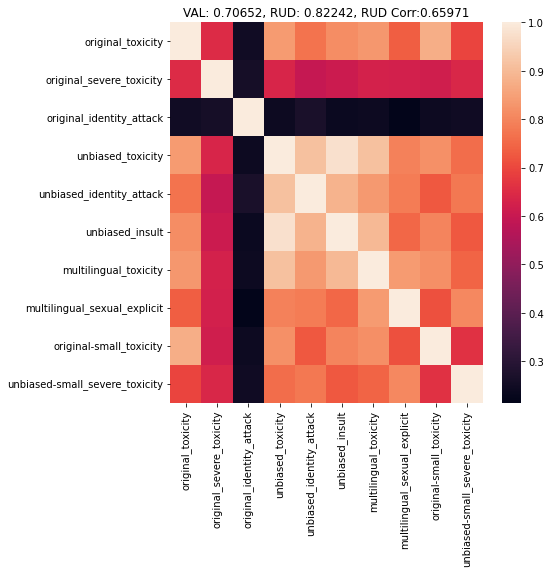

In [10]:
df_corr = rud_text[cols].copy()
for col in cols:
    rud_text[col] = rankdata ( rud_text[col].values )
corr = df_corr.corr()    

A = corr.values
m = A.shape[0]
r,c = np.triu_indices(m,1)
corr_mean = A[r,c].mean()

plt.figure (figsize=(7,7))
sns.heatmap (corr)
plt.title(f"VAL: {val_score:.5f}, RUD: {rud_score:.5f}, RUD Corr:{corr_mean:.5f}")
plt.show()
